In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas
import torch
import SimpleITK as sitk
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.utils import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils import data

In [3]:
# Define file directories
DATA_PATH = 'C:/Users/Kyle/'
data_path = DATA_PATH + 'Desktop/Python/MURA-v1.1/'
sub_path = 'train/XR_HUMERUS/'

In [4]:
#Read a csv file containing file directories
train_xray = pandas.read_csv(data_path + 'train_image_paths.csv', header=None)
train_xray[0] = train_xray[0].astype(str)
humerus_xray = pandas.concat([train_xray], axis=0, ignore_index=True)

In [5]:
# Split image path
imageSplit = train_xray[0].str.split('/', n=5, expand=True)

train_xray['Dataset'] = imageSplit[0]
train_xray['ImageSet'] = imageSplit[1]
train_xray['ImageType'] = imageSplit[2]
train_xray['Patient ID'] = imageSplit[3]
train_xray['DiagnosisType'] = imageSplit[4]
# train_xray['Diagnosis'] = imageSplit[4].str.split('_', n=1, expand=True)[1]
train_xray['Image'] = imageSplit[5]

In [6]:
imageSplit

,0,1,2,3,4,5
0,MURA-v1.1,train,XR_HUMERUS,patient03120,study1_negative,image1.png
1,MURA-v1.1,train,XR_HUMERUS,patient03120,study1_negative,image2.png
2,MURA-v1.1,train,XR_HUMERUS,patient03121,study1_negative,image1.png
3,MURA-v1.1,train,XR_HUMERUS,patient03121,study1_negative,image2.png
4,MURA-v1.1,train,XR_HUMERUS,patient03122,study1_negative,image1.png
...,...,...,...,...,...,...
213,MURA-v1.1,train,XR_HUMERUS,patient03224,study1_negative,image2.png
214,MURA-v1.1,train,XR_HUMERUS,patient03225,study1_negative,image1.png
215,MURA-v1.1,train,XR_HUMERUS,patient03225,study1_negative,image2.png
216,MURA-v1.1,train,XR_HUMERUS,patient03226,study1_negative,image1.png


In [9]:
img_size = 64

xray_image_data = []

In [10]:
xray_image = cv2.imread("MURA-v1.1/train/XR_HUMERUS/patient03120/study1_negative/image2.png", 1) # Change 1 to 0 for grey images
rgb_img = cv2.cvtColor(xray_image, cv2.COLOR_BGR2RGB) # Change BGR to RGB to display true colors
rgb_img = cv2.resize(rgb_img, (64, 64)) # Resize the image
xray_image_data.append(img_to_array(rgb_img))
img_final = np.reshape(xray_image_data, (len(xray_image_data), 64, 64, 3))
img_final = img_final.astype('float32')/255

TypeError: Invalid shape (1, 64, 64, 3) for image data

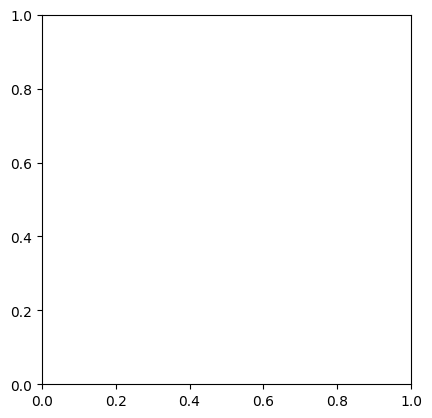

In [20]:
plt.imshow(rgb_img, cmap="gray")

In [15]:
img_final.shape

(1, 64, 64, 3)

In [16]:
img_final

array([[[[0.01568628, 0.01568628, 0.01568628],
         [0.01568628, 0.01568628, 0.01568628],
         [0.01568628, 0.01568628, 0.01568628],
         ...,
         [0.01568628, 0.01568628, 0.01568628],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784]],

        [[0.01568628, 0.01568628, 0.01568628],
         [0.01568628, 0.01568628, 0.01568628],
         [0.01960784, 0.01960784, 0.01960784],
         ...,
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784]],

        [[0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01568628, 0.01568628, 0.01568628],
         ...,
         [0.12156863, 0.12156863, 0.12156863],
         [0.03921569, 0.03921569, 0.03921569],
         [0.01960784, 0.01960784, 0.01960784]],

        ...,

        [[0.01568628, 0.01568628, 0.01568628],
         [0.01568628, 0.01568628, 0.01568628]

In [17]:
img_final/255.0

array([[[[6.1514809e-05, 6.1514809e-05, 6.1514809e-05],
         [6.1514809e-05, 6.1514809e-05, 6.1514809e-05],
         [6.1514809e-05, 6.1514809e-05, 6.1514809e-05],
         ...,
         [6.1514809e-05, 6.1514809e-05, 6.1514809e-05],
         [7.6893506e-05, 7.6893506e-05, 7.6893506e-05],
         [7.6893506e-05, 7.6893506e-05, 7.6893506e-05]],

        [[6.1514809e-05, 6.1514809e-05, 6.1514809e-05],
         [6.1514809e-05, 6.1514809e-05, 6.1514809e-05],
         [7.6893506e-05, 7.6893506e-05, 7.6893506e-05],
         ...,
         [7.6893506e-05, 7.6893506e-05, 7.6893506e-05],
         [7.6893506e-05, 7.6893506e-05, 7.6893506e-05],
         [7.6893506e-05, 7.6893506e-05, 7.6893506e-05]],

        [[7.6893506e-05, 7.6893506e-05, 7.6893506e-05],
         [7.6893506e-05, 7.6893506e-05, 7.6893506e-05],
         [6.1514809e-05, 6.1514809e-05, 6.1514809e-05],
         ...,
         [4.7673972e-04, 4.7673972e-04, 4.7673972e-04],
         [1.5378701e-04, 1.5378701e-04, 1.5378701e-04],
  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 16)        

1/1 [==============================] - 0s 28ms/step - loss: 0.0019 - accuracy: 0.2065
Epoch 59/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0019 - accuracy: 0.2329
Epoch 60/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 0.2629
Epoch 61/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 0.2944
Epoch 62/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 0.3274
Epoch 63/100
1/1 [==============================] - 0s 27ms/step - loss: 0.0017 - accuracy: 0.3567
Epoch 64/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0017 - accuracy: 0.3833
Epoch 65/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0017 - accuracy: 0.4006
Epoch 66/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0016 - accuracy: 0.4055
Epoch 67/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0016 - accuracy: 0.4048
Epoch 68/100
1/1 [=====

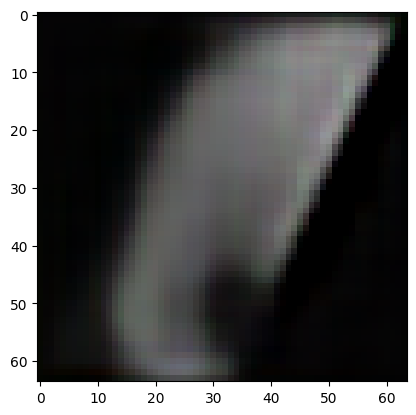

In [19]:
model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64,64,3)))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))

model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(3, (3,3), activation='relu', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model.summary()

model.fit(img_final, img_final, epochs=100,  shuffle=True)

pred=model.predict(img_final)

plt.imshow(pred[0].reshape(64,64,3))